# Основная информация

![](https://static.seekingalpha.com/uploads/2016/5/3/40779175-14623312448942275_origin.jpg)

   Проект делался в рамках учебного курса Data Science от SkillFactory. 
Суть проекта в том, что есть набор данных с характеристиками продуктов Amazon.    Задача состоит в том, чтобы построить модель для прогнозирования рейтинга этих продуктов.


## 1. Установка требуемых библиотек и настройка системы на повторяемость вычислений

In [18]:
# Импортируем библиотеки.
import pandas as pd
from pandas import Series
import numpy as np
import json
from collections import Counter
import ast

import re
import os

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import scipy.sparse as sparse



from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

import warnings # Отмена вывода информационных сообщений
warnings.simplefilter('ignore')

scaler = MinMaxScaler()
cnt = Counter()

%matplotlib inline

In [19]:
# Настройка системы на повторяемость вычислений
LEARNING_RATE = 0.089
RANDOM_STATE = 42
NUM_THREADS = 12
NUM_COMPONENTS = 160 
NUM_EPOCHS = 25
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
current_date = pd.to_datetime('26/02/2021')
!pip freeze > requirements.txt

In [20]:
# Загрузка исходных данных.
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as data:
    meta_list = []
    for line in data.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

In [21]:
meta.head(3)

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN


In [22]:
test.head(3)

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2


In [23]:
train.head(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0


## 2. Предварительное изучение и обработка данных

In [24]:
# Просмотр информации тестовых данных.
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


#### Количество записей - 285 965:
* verified - является ли покупка пользователем продукта проверенной или нет;
* reviewTime - дата проверки;
* asin - стандартный идентификационный номер Amazon;
* reviewerName - имя пользователя, написавшего отзыв;
* unixReviewTime - дата проверки (Unix);
* vote - количество голосов, поданных за отзыв;
* style - стиль
* image - гиперссылка на фотографию продукта, сделанную пользователем;
* userid - идентификатор пользователя;
* itemid - идентификатор продукта;
* Id - идентификатор строки (285 965 записей):


In [25]:
# Просмотр информации тренировочных данных
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


#### Набор данных для обучения имеет -  857 895 записей:
* verified - является ли покупка пользователем продукта проверенной или нет;
* reviewTime - дата рассмотрения;
* asin - стандартный идентификационный номер Amazon;
* reviewerName - имя пользователя, написавшего отзыв;
* unixReviewTime - дата проверки (Unix);
* vote - количество голосов, поданных за отзыв;
* style - стиль
* image - гиперссылка на фотографию продукта, сделанную пользователемидентификатор пользователя;
* userid - идентификатор пользователя;
* itemid - идентификатор продукта.

Функции, которые присутствуют в обучающем наборе данных, которых нет в тестовом наборе данных:
* overall - оценка продукта пользователем по пятибалльной шкале.
* reviewText - текст рецензии.
* summary - краткое изложение обзора.
* rating - целевая переменная, двоичная (0 = 1-3 в целом, 1 = 4-5 в целом).

Функция, которые присутствуют в тестовом наборе данных, которой нет в обучающем наборе данных:
* Id - идентификатор строки.

In [26]:
# Просмотр информации дополнительного набора данных
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


#### Дополнительный набор данных имеет - 287 209 записей:
* category - все категории, к которым относится продукт;
* description - описание продукта;
* title - название продукта;
* brand - марка продукта;
* rank - [Рейтинг бестселлеров](https://www.junglescout.com/blog/amazon-best-sellers-rank/);
* also_view - ASINs продуктов, которые пользователи просматривали вместе с этим продуктом;
* main_cat - основная категория продукта;
* price - цена товара;
* asin - стандартный идентификационный номер Amazon;
* also_buy - ASINs продуктов, которые пользователи видели купленными с помощью этого продукта;
* image - гиперссылка на фотографию продукта, сделанную продавцом;
* date - когда продукт был добавлен в систему (предположительно);
* feature - особенности;
* details - HTML страницы, связанной с продуктом;
* similar_item - описания аналогичных продуктов, содержащие ASIN, название, изображение, характеристики, цену, доставку, поставщика и другие характеристики;
* tech1 - технические характеристики изделия (вес, рост и т.д.));
* fit - только 4 записи, так что ничего важного.

Так как ASIN уникальны и используются во всех наборах данных, можно использовать их для обогащения обучающего набора данных данными из дополнительного набора данных.

#### Посмотрим статистику товаров представленных в тренировочном и тестовом датсетах

In [27]:
print("Количесвто уникальных товаров в Train",len(train.asin.unique()))
print("Количесвто уникальных товаров в Test",len(test.asin.unique()))
print("Количество пересечений в Train/Test",len(set.intersection(set(train.asin), set(test.asin))))

Количесвто уникальных товаров в Train 41302
Количесвто уникальных товаров в Test 37876
Количество пересечений в Train/Test 37858


#### Посмотрим каких товаров нет в тренировочном датасет

In [28]:
unique_obj = set(test.asin) - set.intersection(set(train.asin),set(test.asin))
print("Объекты, которых нет в Train", unique_obj)
for met in unique_obj:
    display(meta[ meta.asin == met])

Объекты, которых нет в Train {'B000WW6VZO', 'B000H25VSM', 'B014LT33M2', 'B000YINEYW', 'B000X0Z9CQ', 'B00L3SU3IC', 'B00ZNK5KQ6', 'B00U69Q0ZE', 'B000GW2406', 'B0015AT3BG', 'B0155W3W7A', 'B00176QPJG', 'B00CP79A84', 'B000YAH13A', 'B0016CZ5L0', 'B001682QMA', 'B0017I1QAW', 'B00XMZB1LC'}


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
28642,"[Grocery & Gourmet Food, Snack Foods, Cookies,...",[This is a fun new way to get a party started ...,"Greenfire Custom Fortune Cookies, for Special ...",Greenfire Custom Fortune Cookies,"478,636inGroceryGourmetFood(","[B074Q3CH6C, B000I07O10, B000CBEP9O, B00750E0X...",Grocery,$275.00,B000WW6VZO,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
15162,"[Grocery & Gourmet Food, Sauces, Gravies & Mar...",[Chipotle peppers are a smoked red jalapeno pe...,"Embasa Chipotle Peppers in Adobo Sauce, 7-Ounc...",Embasa,"177,661inGroceryGourmetFood(","[B000QJSACU, B00061DFEQ, B00G0JSW0U, B0014CVT6...",Grocery,$27.01,B000H25VSM,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
256270,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[, Buttered Popcorn is pretty much the best th...",Real Popcorn Butter Topping Tru-POP 12oz NEW ITEM,Just Poppin,"102,077inGroceryGourmetFood(","[B00K2B4AY4, B01CDBBB92, B002YLNUL4, B0785827P...",Grocery,$19.99,B014LT33M2,"[B0051WBPHY, B004W8LT10, B01CDBBB92, B01BO3E7E...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
29330,"[Grocery & Gourmet Food, Beverages, Bottled Be...","[Apple Tea, Safety button pops up when origina...",Snapple FruitJuice Apple 16 oz Glass Bottle (6...,Snapple,"160,137inGroceryGourmetFood(","[B004OE2Z3I, B06VSG521B, B07B1L2KNS, B07GRBQ76...",Grocery,NaN,B000YINEYW,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
28682,"[Grocery & Gourmet Food, Breads & Bakery, Cakes]",[Hsin Tung Yang Green Bean Cake with Red Bean ...,Traditional Taiwanese All Natural Vegetarian S...,NineChef,"258,584inGroceryGourmetFood(","[B06Y6TYWFK, B001M04TC2, B00E5OB0JM, B07FYX19G...",Grocery,$10.00,B000X0Z9CQ,"[B001M04TC2, B00E5OB0JM, B0051D83SW, B01LZSA84...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
202117,"[Grocery & Gourmet Food, Beverages, Bottled Be...",[Easy for on the go use. All naturally sweeten...,Skinnygirl Liquid Water Enhancer White Cherry ...,Skinnygirl,"65,518inGroceryGourmetFood(",NaN,Grocery,$33.95,B00L3SU3IC,"[B00J80X54G, B00K9EYJ36, B00K330E46, B00J815O1...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
248305,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Our first offering from the exclusive Oaks te...,2017 Harvest Premium Darjeeling Loose Leaf Bla...,Vahdam Teas,"330,516inGroceryGourmetFood(","[B014GLC2LS, B014WCN60M, B00VFYPG1S, B00S0NYCCG]",Grocery,NaN,B00ZNK5KQ6,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
236034,"[Grocery & Gourmet Food, Beverages, Coffee, Te...","[A seductive mix of full-bodied Arabica beans,...","Double Donut Italian Roast Coffee, in Recyclab...",Double Donut,"170,729inGroceryGourmetFood(",NaN,Grocery,$12.30,B00U69Q0ZE,"[B00U69Q6JE, B00U69Q03G, B013HNTQII, B013HNTXM...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
14753,"[Grocery & Gourmet Food, Snack Foods, Jerky & ...","[Super size., Beef, Salt, Corn Syrup, Spices, ...","Jack Link's Super Size Beef Sticks, Original, ...",Jack Links,NaN,NaN,Grocery,NaN,B000GW2406,NaN,NaN,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
32960,"[Grocery & Gourmet Food, Candy & Chocolate, Ca...","[Chewy, vanilla flavored nougat wrapped in a r...",Charleston Chew Bar Vanilla 24 Pac,Charleston Chew,"30,981inGroceryGourmetFood(","[B00A8HSA52, B003EYNJMA, B003VTLOQQ, B07J5W562...",Grocery,$25.59,B0015AT3BG,"[B0015AUZ04, B003VTLOQQ, B003WEDT4A, B00A8HSA5...",NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
257471,"[Grocery & Gourmet Food, Cooking & Baking, Coo...",NaN,Extra Virgin First Cold Pressed Olive Oil 500m...,Mt. Kofinas Olive Oil,"170,642inGroceryGourmetFood(",NaN,Grocery,$19.95,B0155W3W7A,"[B01EPAH03U, B01NB1ZNS5, B005WF768C, B00CX6WT9...",[https://images-na.ssl-images-amazon.com/image...,NaN,"[Mediterranean diet staple, Ancient health foo...","\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
34246,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[This is a multi-layered blend of medium- and ...,Caffe Vita Queen City Whole Bean (Medium-Dark)...,Caffe Vita,"41,297inGroceryGourmetFood(","[B002GJY2CU, B00176MUH2, B00176QPH8, B01N4JBH3...",Grocery,$22.50,B00176QPJG,"[B002GJY2CU, B00176MUH2, B00176QPH8, B00176QPI...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
146744,"[Grocery & Gourmet Food, Beverages, Bottled Be...",NaN,"Glaceau Smart Water, 500ml (Pack of 12)",vitaminwater,"69,774inGroceryGourmetFood(",NaN,Grocery,$29.44,B00CP79A84,"[B073WWZ22T, B01MSY8JI9, B06XZYX65P, B00KIG3WP...",NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
29071,"[Grocery & Gourmet Food, Food & Beverage Gifts...",[Send your heartfelt sympathy to friends and l...,Art of Appreciation Gift Baskets With Heartfel...,Art of Appreciation Gift Baskets,"229,506inGroceryGourmetFood(","[B00F4WIQ96, B00ZRWPZPQ, B00QPHNUYU, B0097GS4I...",Grocery,$49.99,B000YAH13A,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
33896,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",[Novus Citrus Chamomile Herbal Tea is made sin...,"Novus Citrus Chamomile Herbal Tea, Caffeine Fr...",3M,"917,358inGroceryGourmetFood(",NaN,Grocery,NaN,B0016CZ5L0,NaN,NaN,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Package ...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
33601,"[Grocery & Gourmet Food, Breads & Bakery, Pizz...",[Appian Way Pizza complete with crust mix and ...,Appian Way Pizza Crust Mix (Pack of 12),Appian Way,"187,815inGroceryGourmetFood(","[B0025UCFYC, B00IDPSOR0, B00IDPOPSW, B00IDPX1V...",Grocery,$56.99,B001682QMA,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
34324,"[Grocery & Gourmet Food, Snack Foods, Salsas, ...","[Arriba! Salsas deliver a rich, fresh, grilled...","Arriba! Fire Roasted Mexican Red Salsa, Hot, 1...",Arriba!,"444,147inGroceryGourmetFood(","[B001HTKV1G, B00CIVY3FW, B00A9OEUJY, B00HMUUU60]",Grocery,$26.49,B0017I1QAW,NaN,NaN,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
244679,"[Grocery & Gourmet Food, Condiments & Salad Dr...",[Mustards from the Dijon region of France are ...,"Maille Old Style Grain Dijon Mustard, 7.3 oz",Maille,"53,058inGroceryGourmetFood(",NaN,Grocery,$14.99,B00XMZB1LC,"[B0053OD50A, B0027HUUNG, B0001BH5YM, B078P773N...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [29]:
# Просмотр верифицированных покупок
train.verified.value_counts()


True     745243
False    112652
Name: verified, dtype: int64

### Посмотрим распределения рейтинга товаров и оценок товаров

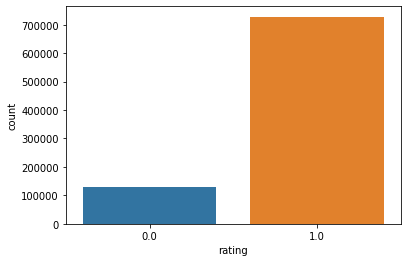

In [30]:
ax = sns.countplot(x="rating", data=train)

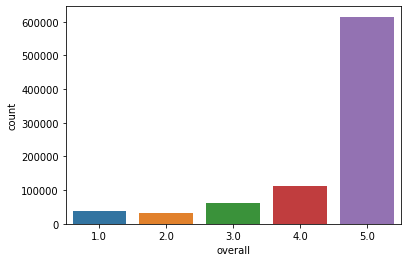

In [31]:
ax = sns.countplot(x="overall", data=train)

# 3. Дубликаты и слияние

In [32]:
# Удаление дубликатов
meta = meta.iloc[meta.astype(str).drop_duplicates().index]
train = train.drop_duplicates()

In [33]:
# Объединение наборов данных.
train['sample'] = 1
test['sample'] = 0
test['rating'] = -1
data = test.append(train, sort=False).reset_index(drop=True)
data_enriched = pd.merge(data, meta, on='asin')

In [34]:
# Проверка данных
data_enriched.info()
data_enriched.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 32 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   verified        1114900 non-null  bool   
 1   reviewTime      1114900 non-null  object 
 2   asin            1114900 non-null  object 
 3   reviewerName    1114689 non-null  object 
 4   unixReviewTime  1114900 non-null  int64  
 5   vote            155453 non-null   object 
 6   style           576945 non-null   object 
 7   image_x         9394 non-null     object 
 8   userid          1114900 non-null  int64  
 9   itemid          1114900 non-null  int64  
 10  Id              285965 non-null   float64
 11  sample          1114900 non-null  int64  
 12  rating          1114900 non-null  float64
 13  overall         828935 non-null   float64
 14  reviewText      828661 non-null   object 
 15  summary         828769 non-null   object 
 16  category        1114900 non-null  ob

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image_x,userid,itemid,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,True,"01 20, 2016",B001E5E3X0,Asteroide 699,1453248000,NaN,NaN,NaN,58293,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,True,"02 5, 2017",B001E5E3X0,Tito in CR,1486252800,NaN,NaN,NaN,36496,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
3,True,"02 24, 2013",B001E5E3X0,Gingercook,1361664000,NaN,NaN,NaN,95606,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
4,True,"06 11, 2015",B001E5E3X0,Kindle Customer,1433980800,NaN,NaN,NaN,15601,7506,...,Grocery,$39.05,"[B005P7YSG0, B005P7YQ7Q, B001M0A8Y0, B004AM21B...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


# 4. Очистка данных и разработка признаков

## 4.1 Подтвержденная покупка

In [35]:
# Кодирование категориальной переменной.
verified_dict = {
    True: 1,
    False: 0
}

data_enriched['verified'] = data_enriched['verified'].map(verified_dict)

## 4.2 Время просмотра

"ReviewTime" содержит те же данные, что и "unixReviewTime", поэтому давайте отбросим его позже.

## 4.3 ASIN (стандартный идентификационный номер Amazon)

Создадим словарь из ASINs и идентификаторов продуктов, на случай, если нам понадобится перекодировать данные.

In [36]:
# Создание словаря ASINs и идентификаторов элементов IDs.
asin_list = []
itemid_list = []

for asin in data_enriched['asin']:
    asin_list.append(asin)
    
for itemid in data_enriched['itemid']:
    itemid_list.append(itemid)
    
asin_dict = dict(zip(asin_list, itemid_list))

pd.DataFrame(asin_dict.items(), columns=['asin', 'itemid']).to_csv('asin_itemid.csv')

## 4.4 Имя рецензента

In [37]:
# Проверка данных
data_enriched['reviewerName'].value_counts().head(30)

Amazon Customer    41309
Kindle Customer     8086
Linda                967
John                 920
David                786
Mike                 732
Mary                 719
Karen                697
Michael              693
Susan                648
Chris                639
Jennifer             632
Steve                611
Cindy                581
Doug Erlandson       558
Lisa                 547
Michelle             532
Nancy                525
Annie                517
Anonymous            505
J                    493
Barbara              487
Alex                 478
Lynn                 477
Jim                  475
CJ                   475
Laura                475
Dan                  469
Donna                465
Sarah                461
Name: reviewerName, dtype: int64

Много клиентов Kindle. Можем использовать его для создания новой функции.

In [38]:
# Создание нового признака
data_enriched['kindle_customer'] = 0

counter = 0

for name in data_enriched['reviewerName']:     
    if name == 'Kindle Customer':
        data_enriched.at[counter,'kindle_customer'] = 1
        counter += 1
    else:
        counter += 1

## 4.5 Время просмотра (Unix)

In [39]:
# Просмотр данных
data_enriched['unixReviewTime']

0          1475280000
1          1453248000
2          1486252800
3          1361664000
4          1433980800
              ...    
1114895    1508716800
1114896    1473552000
1114897    1477526400
1114898    1416441600
1114899    1493424000
Name: unixReviewTime, Length: 1114900, dtype: int64

## 4.6 Голосов за отзыв

По какой-то причине в наборе данных нет значений с одним голосом, поэтому вместо нулевого значения будем заполнять NaNs  - единицей.

In [40]:
# Заполнение недостающих значений.
data_enriched['vote'] = data_enriched['vote'].fillna(1)

Конвертируем данные в тип int.

In [41]:
# Конвертирование данных
data_enriched['vote'] = data_enriched['vote'].astype('str').apply(
    lambda x: x.replace(',', ''))

data_enriched['vote'] = data_enriched['vote'].astype('float64')
data_enriched['vote'] = data_enriched['vote'].astype('int64')

## 4.7 Стиль

In [42]:
# Просмотр данных
data_enriched['style'].dropna().sample(20)

266063                          {'Size:': ' 2 Lb 8.5 Ounce'}
39449                      {'Size:': ' .625oz (Pack of 32)'}
341491                   {'Flavor:': ' Skinless & Boneless'}
35326         {'Size:': ' 16 Ounce', 'Flavor:': ' Original'}
36347                   {'Flavor:': ' Strawberry and Cream'}
382224                    {'Size:': ' 16 Ounce (Pack of 4)'}
508654                                      {'Size:': ' 20'}
363222     {'Size:': ' 10 Ounce (Pack of 6)', 'Flavor:': ...
336038                                 {'Size:': ' 2 Ounce'}
1023137           {'Size:': ' 8 Ounce', 'Flavor:': ' Onion'}
88671                          {'Size:': ' 2 Pounds X-Fine'}
312965                 {'Size:': ' 1 lb.', 'Style:': ' Bag'}
313064                 {'Size:': ' 8 oz.', 'Style:': ' Bag'}
963881                        {'Size:': ' Cinnamon 2 Fl Oz'}
533421     {'Size:': ' 1 fl oz', 'Flavor:': ' Lemon Extra...
934397     {'Size:': ' 72 Count', 'Flavor:': ' Big Easy B...
852900     {'Size:': ' 1

Признак содержит техническую информацию

## 4.8 Фотографии (от пользователя или поставщика)

Наличие предоставленной пользователем фотографии делает отзыв гораздо более надежным, поэтому давайте создадим этот признак. Мы также создадим флаг для фотографий, предоставленных поставщиком.

In [43]:
# Создание нового признака
data_enriched['user_photo'] = 0
data_enriched['vendor_photo'] = 0

counter = 0
data_enriched['image_x'] = data_enriched['image_x'].fillna(0)
for image in data_enriched['image_x']:
    if image != 0:
        data_enriched.at[counter,'user_photo'] = 1
        counter += 1
    else:
        counter += 1

counter = 0
data_enriched['image_y'] = data_enriched['image_y'].fillna(0)
for image in data_enriched['image_y']:
    if image != 0:
        data_enriched.at[counter,'vendor_photo'] = 1
        counter += 1
    else:
        counter += 1

## 4.9 User ID (идентификатор пользователя), Item ID (идентификатор элемента), Row ID (идентификатор строки) (index)

Id-это просто индекс строки, удалим его позже. Запишем количество отзывов, оставленных пользователем, и популярность продукта (количество отзывов на продукт).


In [44]:
# Создание нового признака
user_activity_dict = data_enriched['userid'].value_counts().to_dict()
data_enriched['reviews_by_user'] = data_enriched['userid'].map(user_activity_dict)

item_popularity_dict = data_enriched['itemid'].value_counts().to_dict()
data_enriched['reviews_of_item'] = data_enriched['itemid'].map(item_popularity_dict)

Определим коэффициент проверенных покупок товара.

In [45]:
# Создание нового признака
verified_count = data_enriched.groupby('itemid').count()['verified']
verified_sum = data_enriched.groupby('itemid').sum()['verified']
verified_ratio = verified_sum / verified_count
verified_ratio_dict = verified_ratio.to_dict()

data_enriched['verified_purchases_ratio'] = data_enriched['itemid'].map(verified_ratio_dict)

## 4.10 Рейтинг (бинарный) + Общий (5 звезд)

Рейтинг-это целевой признак, он двоичный (0 = 1-3 в целом, 1 = 4-5 в целом). В целом это напрямую связано с рейтингом, поэтому после анализа данных эту функцию можно удалить.

## 4.11 Обзор + Резюме

Проведём семантический анализ отзывов.

In [46]:
# Обработка данных.
data_enriched['reviewText'] = data_enriched['reviewText'].astype('str')
data_enriched['reviewText'] = data_enriched['reviewText'].apply(
    lambda x: re.sub("[^\w]", " ",  x.lower()))

data_enriched['summary'] = data_enriched['summary'].astype('str')
data_enriched['summary'] = data_enriched['summary'].apply(
    lambda x: re.sub("[^\w]", " ",  x.lower()))

In [47]:
# Извлечение полного списка слов из обзоров.
all_words = []

for words in data_enriched['reviewText']:
    all_words.extend(words)
    
for word in all_words:
    cnt[word] +=1
    
words_data = pd.DataFrame.from_dict(cnt, orient='index').sort_values(0, ascending=False)
words_data.to_csv('words_data.csv')

In [48]:
# Создадим списки оценочных слов (хороших и плохих).

good_words_list = [
    "best",
    "good",
    "great",
    "love",
    "delicious",
    "nice",
    "favorite",
    "tasty",
    "perfect",
    "excellent",
    "wonderful",
    "enjoy",
    "yummy",
    "happy",
    "loves",
    "loved",
    "amazing",
    "awesome",
    "yum",
    "enjoyed",
    "fantastic",
    "perfectly",
    "wow",
    "lovely",
    "beautiful",
    "terrific",
    "enjoyable"
]

bad_words_list = [
    "awful",
    "bad",
    "disappointed",
    "unfortunate",
    "waste",
    "weird",
    "difficult",
    "terrible",
    "horrible",
    "complaint",
    "gross",
    "worst",
    "strange",
    "fake",
    "disappointing",
    "complaints",
    "poor",
    "sucks"
]

In [49]:
# Создадим новые признаки
data_enriched['good_review'] = 0
data_enriched['bad_review'] = 0
data_enriched['good_summary'] = 0
data_enriched['bad_summary'] = 0

In [50]:
# Заполним новые признаки.
counter = 0
for review in data_enriched['reviewText']:
    for word in good_words_list:
        if word in review:
            data_enriched.at[counter,'good_review'] = 1
            counter += 1
            break
    else:
        counter += 1

        
counter = 0
for review in data_enriched['reviewText']:
    for word in bad_words_list:
        if word in review:
            data_enriched.at[counter,'bad_review'] = 1
            counter += 1
            break
    else:
        counter += 1
        
        
counter = 0
for summary in data_enriched['summary']:
    for word in good_words_list:
        if word in summary:
            data_enriched.at[counter,'good_summary'] = 1
            counter += 1
            break
    else:
        counter += 1
        
        
counter = 0
for summary in data_enriched['summary']:
    for word in bad_words_list:
        if word in summary:
            data_enriched.at[counter,'bad_summary'] = 1
            counter += 1
            break
    else:
        counter += 1

Оценим количество плохих и хороших отзывов по каждому продукту.

In [51]:
# Создадим новые признаки.
good_reviews_dict = data_enriched.groupby('itemid').sum().to_dict()['good_review']
bad_reviews_dict = data_enriched.groupby('itemid').sum().to_dict()['bad_review']

data_enriched['item_good_reviews'] = data_enriched['itemid'].map(good_reviews_dict)
data_enriched['item_bad_reviews'] = data_enriched['itemid'].map(bad_reviews_dict)

## 4.12 Описание + Название

Вместо описания продукта и его названия мы будем использовать идентификатор продукта или категорию продукта, это гораздо точнее.

## 4.13 Категория

In [52]:
# Просмотр данных
data_enriched['category'].explode().value_counts()

Grocery & Gourmet Food    1114900
Beverages                  295332
Coffee, Tea & Cocoa        228831
Cooking & Baking           216190
Snack Foods                140261
                           ...   
Tomatillos                      5
Red                             5
Camembert                       5
Marshmallow                     5
Tulips                          3
Name: category, Length: 1003, dtype: int64

Признак объёмный, мы постараемся сделать из нее фиктивные переменные позже, а затем удалить ее.

## 4.14 Бренд

Создадим новые переменные: сумму хороших и плохих отзывов о бренде, отношение проверенных покупок продукта ко всем покупкам этого бренда, а также количество продуктов внутри бренда. После этого мы заполним пробелы "no_brand_provided".

In [53]:
# Обработка данных.
data_enriched['brand'] = data_enriched['brand'].astype('str')
data_enriched['brand'] = data_enriched['brand'].apply(
    lambda x: re.sub("[^\w]", "",  x.lower()))

In [54]:
# Создание нового признака
good_reviews_dict = data_enriched.groupby('brand').sum().to_dict()['good_review']
bad_reviews_dict = data_enriched.groupby('brand').sum().to_dict()['bad_review']

data_enriched['brand_good_reviews'] = data_enriched['brand'].map(good_reviews_dict)
data_enriched['brand_bad_reviews'] = data_enriched['brand'].map(bad_reviews_dict)

In [55]:
# Создание нового признака
verified_count = data_enriched.groupby('brand').count()['verified']
verified_sum = data_enriched.groupby('brand').sum()['verified']
verified_ratio = verified_sum / verified_count
verified_ratio_dict = verified_ratio.to_dict()

data_enriched['brand_verified_ratio'] = data_enriched['brand'].map(verified_ratio_dict)

In [56]:
# Создание нового признака
brand_items_dict = data_enriched.groupby('brand').count()['itemid'].to_dict()

data_enriched['items_per_brand'] = data_enriched['brand'].map(brand_items_dict)

In [57]:
# Заполнение недостающих значений
data_enriched['brand'] = data_enriched['brand'].fillna('no_brand_provided')

## 4.15 BSR (Рейтинг бестселлеров)

После проверки пользовательского интерфейса Amazon выесняется, что рейтинг - это внутренний рейтинг продаж продукта в категории ([Рейтинг лучших продавцов, BSR](https://www.amazon.com/gp/help/customer/display.html?nodeId=GGGMZK378RQPATDJ)). 
Чем ниже ПЛАНКА, тем лучше продается товар в указанной категории.

In [58]:
# Просмотр данных
data_enriched['asin'][data_enriched['rank'].isna()==True].value_counts()

B00112O8NG    1049
B000E8WIAS     693
B0012OTF3Q     660
B00099XK6I     546
B000WLGCPY     440
              ... 
B00113U76W       2
B000WG7HI0       2
B000WH5VAK       2
B000WG851I       2
B0014E4D40       1
Name: asin, Length: 2441, dtype: int64

Мы видим [пример](https://www.amazon.ca/Torani-Sugar-Vanilla-Flavor-Syrup/dp/B00112O8NG) что продукты без БАРА в наборе данных на самом деле могут иметь BSR на сайте.

In [59]:
# Просмотр данных
data_enriched['rank'][0]

'51,991inGroceryGourmetFood('

In [60]:
# Просмотр данных
data_enriched['rank'][360688]

'>#123,342 in Grocery & Gourmet Food (See Top 100 in Grocery & Gourmet Food)>#169 in Grocery & Gourmet Food > Cooking & Baking > Nuts & Seeds > Pistachios>#3,081 in Grocery & Gourmet Food > Snack Foods > Nuts & Seeds>#4,715 in Grocery & Gourmet Food > Produce'

Углубляясь глубже, обноруживаем, что признак может содержать до 4 рангов в различных категориях. Усложняет ситуацию то, что категории могут иметь разное происхождение, но схожие названия. Давайте оставим первый, потому что он обычно описывает родительскую категорию.

In [61]:
# Обработка данных.
data_enriched['rank'] = data_enriched['rank'].astype(str).apply(
    lambda x: re.sub("in.*", "",  x))

data_enriched['rank'] = data_enriched['rank'].astype(str).apply(
    lambda x: re.sub("[^\d*]", "",  x))

data_enriched['rank'] = pd.to_numeric(data_enriched['rank'])

Чтобы заполнить пробелы, используем медианное значение ранга по категориям, но перед этим мы вручную заполним пробелы в разделе "Ребенок", где у нас нет такого значения.

In [62]:
# Обработка данных.
data_enriched[data_enriched['main_cat'] == 'Baby']['asin'].value_counts()

B0015H1D4E    29
B00FNIZQ6W    14
B00H8B37UO     7
Name: asin, dtype: int64

Изучив ASIN, видим, что все это продукты питания, поэтому категорию можно изменить на продуктовую.

In [63]:
baby_list = data_enriched[data_enriched['main_cat'] == 'Baby'].index.to_list()

for index in baby_list:
    data_enriched.at[index,'main_cat'] = 'Grocery'

Есть ещё значения без основной категории, мы используем значение "No category"для заполнения.

In [64]:
# Обработка данных.
data_enriched[data_enriched['rank'].isna()==True]['main_cat'].value_counts(dropna=False)

Grocery                   46279
NaN                         193
Health & Personal Care      179
Amazon Home                  54
Name: main_cat, dtype: int64

In [65]:
# Заполнение недостающих значений.
data_enriched['main_cat'] = data_enriched['main_cat'].fillna('no_category_provided')

In [66]:
# Заполнение недостающих значений.
median_rank_dict = data_enriched.groupby('main_cat').median().to_dict()['rank']

data_enriched['rank'] = data_enriched['rank'].fillna(data_enriched['main_cat'].map(median_rank_dict))

## 4.16 Also Buy + Also View

На основе атрибутов "also_buy" и "also_view" мы создадим новые столбцы - факт наличия и количество продуктов в списках.

In [67]:
# Создание новых признаков

data_enriched['no_also_buy'] = pd.isna(data_enriched['also_buy']).astype('uint8')
data_enriched['no_also_view'] = pd.isna(data_enriched['also_view']).astype('uint8')


data_enriched['also_buy_number'] = data_enriched['also_buy'].str.len()
data_enriched['also_view_number'] = data_enriched['also_view'].str.len()

data_enriched['also_buy_number'] = data_enriched['also_buy_number'].fillna(0)
data_enriched['also_view_number'] = data_enriched['also_view_number'].fillna(0)

## 4.17 Основная категория

In [68]:
# Обработка данных.
data_enriched['main_cat'].value_counts(dropna=False)

Grocery                      1055152
Health & Personal Care         42908
Amazon Home                     9324
All Beauty                      1962
Sports & Outdoors               1489
no_category_provided            1289
Industrial & Scientific         1225
Office Products                  843
Toys & Games                     402
Pet Supplies                     169
Tools & Home Improvement          74
Arts, Crafts & Sewing             25
Home Audio & Theater              11
Camera & Photo                     9
Musical Instruments                8
Cell Phones & Accessories          5
Software                           5
Name: main_cat, dtype: int64

Атрибут представляет родительскую категорию продукта. Позже мы сможем сделать из него фиктивные переменные.

## 4.18 Цена

In [69]:
# Просмотр данных
data_enriched['price'].value_counts()

$14.99     18838
$13.67     14307
$19.99     12059
$14.79      7539
$15.53      7308
           ...  
$62.24         3
$264.87        2
$49.06         2
$6.93          1
$275.00        1
Name: price, Length: 4603, dtype: int64

In [70]:
# Обработка данных.
data_enriched['price'] = data_enriched['price'].astype('str').apply(
    lambda x: x.replace('$', ''))

data_enriched[data_enriched['price'].str.contains("-") == True]['price'].value_counts()

8.34 - 249.88     799
15.49 - 40.84     451
19.49 - 36.50     237
21.00 - 192.46    223
8.98 - 59.01      220
                 ... 
38.00 - 890.63      6
54.99 - 815.63      6
38.00 - 892.50      6
21.19 - 219.30      6
19.99 - 295.00      4
Name: price, Length: 74, dtype: int64

Цена в некоторых местах выглядит как диапазон, но она все еще описывает розничный продукт ([пример] (https://www.amazon.com/Wilton-Meringue-Powder-16-oz/dp/B000ZEIR6U)), поэтому логично использовать более низкий запас для замены. Перед этим мы пометим продукты, где указан ассортимент.

In [71]:
# Создание нового признака
data_enriched['price_range'] = 0

price_range_list = data_enriched[
    data_enriched['price'].str.contains("-") == True
].index.to_list()

for index in price_range_list:
    data_enriched.at[index,'price_range'] = 1

In [72]:
# Обработка данных.
data_enriched['price'] = data_enriched['price'].apply(
    lambda x: re.sub("-.*", "",  x))

data_enriched['price'] = data_enriched['price'].astype('float64')

Заполним пробелы медианной ценой для родительской категории.

In [73]:
# Просмотр данных
data_enriched.groupby('main_cat').median()['price']

main_cat
All Beauty                   12.63
Amazon Home                  14.17
Arts, Crafts & Sewing         9.95
Camera & Photo                 NaN
Cell Phones & Accessories      NaN
Grocery                      16.99
Health & Personal Care       15.53
Home Audio & Theater           NaN
Industrial & Scientific      20.99
Musical Instruments            NaN
Office Products              16.97
Pet Supplies                 36.68
Software                       NaN
Sports & Outdoors             9.12
Tools & Home Improvement     34.99
Toys & Games                  9.17
no_category_provided         13.95
Name: price, dtype: float64

В некоторых категориях нет цены, посмотрим, с чем это связано.

In [74]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Camera & Photo']['title'].value_counts()

Cosyzone Windshield Sunshade 6 Pieces Car Sun Shade Side Rear Window Shades UV Rays Sun Visor Protector, Keeps Vehicle Cooler    9
Name: title, dtype: int64

In [75]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Camera & Photo']['asin'].value_counts()

B01E4GD3P4    9
Name: asin, dtype: int64

In [76]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Camera & Photo']['summary']

1027649                                                  nan
1027650          great nuts  i have six of them with one    
1027651        i get to walk memory and the product is ex...
1027652                                    love to eat these
1027653                             good flavor  recommended
1027654                 piping rock brazil nuts raw unsalted
1027655                                soft textured   chewy
1027656                                           four stars
1027657                                          brazil nuts
Name: summary, dtype: object

Судя по названию, это лобовое стекло, судя по категории - фото-сопутствующий товар, судя по отзывам - что-то съедобное, и в интернете такого нет. Давайте положимся на отзывы и изменим категорию на "Бакалея".

In [77]:
# Обработка данных
camera_list = data_enriched[data_enriched['main_cat'] == 'Camera & Photo'].index.to_list()

for index in camera_list:
    data_enriched.at[index,'main_cat'] = 'Grocery'

In [78]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Cell Phones & Accessories']['reviewText'][794706]

'it s a little heart with a gorgeous gift box and sweet little note from the company  though it be little  there is waaay too much chocolate  the heart itself is all chocolate     i gifted this to my husband  because valentines is not gender specific  and he ate about three pieces and it s just sitting in the fridge  i ll eat a piece every now and then but i guess the thought of there being so much chocolate   just overwhelms my appetite  it is delicious though and i love milk chocolate so it was a no brainer for me  it s been 4 days since valentines  i m sure i ll still have the chocolate 4 days after today  don t worry about it cracking on the way to your loved one  mine had too much bubble wrap in my box and it came tightly packaged  trust me  it s not going to crack  there was no product guarantee in the product description during the time of my purchase   i was not paid or sponsored by the seller or by the company for my unbiased review  i stand by my assessment and believe it to 

Аналогично и в категории "Cell Phones" - заявлено ASIN не существует, а отзывы идут о каком-то шоколадном подарке. Давайте изменим категорию на "Grocery".

In [79]:
# Обработка данных
phone_list = data_enriched[data_enriched['main_cat'] == 'Cell Phones & Accessories'].index.to_list()

for index in phone_list:
    data_enriched.at[index,'main_cat'] = 'Grocery'

In [80]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Home Audio & Theater']['summary']

1071366                                                  nan
1071367                                                  nan
1071368                           ok for something different
1071369                                   crio bru maracaibo
1071370                                              love it
1071371    so delicious  especially with a splash of vani...
1071372                                     my new favorite 
1071373    another wonderful variety of crio bru  i m on ...
1071374                             not my favorite crio bru
1071375     so this works great  i use a tea ball to make it
1071376                                           delicious 
Name: summary, dtype: object

Схожая ситуация "Home Audio & Theater".

In [81]:
# Обработка данных
theater_list = data_enriched[data_enriched['main_cat'] == 'Home Audio & Theater'].index.to_list()

for index in theater_list:
    data_enriched.at[index,'main_cat'] = 'Grocery'

In [82]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Musical Instruments']['summary']

622788                                                  nan
622789                                                  nan
622790                                                  nan
622791                                                  nan
622792                                                  nan
622793    real guitar look and feel encourages seriousne...
622794                   excellent beginner guitar for kids
622795                                great beginner guitar
Name: summary, dtype: object

В "Musical Instruments" все правильно, так как ASIN и названия совпадают. [За гитару нет цены](https://www.amazon.co.uk/Martin-Smith-Classical-Guitar-Natural/dp/B0079VKTSQ), но аналоги стоят 20-35 долларов, поэтому мы установим среднее - 27,5.

In [83]:
# Обработка данных
musical_list = data_enriched[data_enriched['main_cat'] == 'Musical Instruments'].index.to_list()

for index in musical_list:
    data_enriched.at[index,'price'] = 27.5

In [84]:
# Просмотр данных
data_enriched[data_enriched['main_cat'] == 'Software']['asin'].value_counts()

B00FCZHEAW    5
Name: asin, dtype: int64

В 'Software', так же ASIN и имена тоже одинаковые. [Product price  - 30.3.](https://www.amazon.com/DESIGNCAD-V22-2D-CAD-PROGRAM/dp/B00FCZHEAW)

In [85]:
# Обработка данных
software_list = data_enriched[data_enriched['main_cat'] == 'Software'].index.to_list()

for index in software_list:
    data_enriched.at[index,'price'] = 30.3

In [86]:
# Заполнение недостающих значений
median_price_dict = data_enriched.groupby('main_cat').median().to_dict()['price']

data_enriched['price'] = data_enriched['price'].fillna(
    data_enriched['main_cat'].map(median_price_dict))

Создадим новые атрибуты - среднюю и среднюю цену для категории и для бренда. Мы также создадим средний и средний рейтинг для продукта и бренда.

In [87]:
# Создание новых признаков

mean_price_dict = data_enriched.groupby('main_cat').mean().to_dict()['price']
median_price_dict = data_enriched.groupby('main_cat').median().to_dict()['price']

data_enriched['category_mean_price'] = data_enriched['main_cat'].map(mean_price_dict)
data_enriched['category_median_price'] = data_enriched['main_cat'].map(median_price_dict)

mean_price_dict = data_enriched.groupby('brand').mean().to_dict()['price']
median_price_dict = data_enriched.groupby('brand').median().to_dict()['price']

data_enriched['brand_mean_price'] = data_enriched['brand'].map(mean_price_dict)
data_enriched['brand_median_price'] = data_enriched['brand'].map(median_price_dict)

mean_overall_dict = data_enriched.groupby('itemid').mean().to_dict()['overall']
median_overall_dict = data_enriched.groupby('itemid').median().to_dict()['overall']

data_enriched['item_mean_overall'] = data_enriched['itemid'].map(mean_overall_dict)
data_enriched['item_median_overall'] = data_enriched['itemid'].map(median_overall_dict)

data_enriched['item_mean_overall'] = data_enriched['item_mean_overall'].fillna(
    data_enriched['item_mean_overall'].mean())
data_enriched['item_median_overall'] = data_enriched['item_median_overall'].fillna(
    data_enriched['item_mean_overall'].median())

mean_overall_dict = data_enriched.groupby('brand').mean().to_dict()['overall']
median_overall_dict = data_enriched.groupby('brand').median().to_dict()['overall']

data_enriched['brand_mean_overall'] = data_enriched['brand'].map(mean_overall_dict)
data_enriched['brand_median_overall'] = data_enriched['brand'].map(median_overall_dict)

data_enriched['brand_mean_overall'] = data_enriched['brand_mean_overall'].fillna(
    data_enriched['brand_mean_overall'].mean())
data_enriched['brand_median_overall'] = data_enriched['brand_median_overall'].fillna(
    data_enriched['brand_median_overall'].median())

## 4.19 Другие функции (date, feature, details, similar_item, tech1, fit)

Для этих переменных слишком мало наблюдений.

In [88]:
# Удаление бесполезных данных
data_enriched = data_enriched.drop([
    'reviewTime',
    'asin',
    'reviewerName',
    'style',
    'image_x',
    'image_y',
    'Id',
    'reviewText',
    'summary',
    'description',
    'title',
    'date', 
    'feature', 
    'details',
    'similar_item', 
    'tech1',
    'fit'
], axis=1)

In [89]:
# Просмотр данных
data_enriched.info()
data_enriched.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 44 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   verified                  1114900 non-null  int64  
 1   unixReviewTime            1114900 non-null  int64  
 2   vote                      1114900 non-null  int64  
 3   userid                    1114900 non-null  int64  
 4   itemid                    1114900 non-null  int64  
 5   sample                    1114900 non-null  int64  
 6   rating                    1114900 non-null  float64
 7   overall                   828935 non-null   float64
 8   category                  1114900 non-null  object 
 9   brand                     1114900 non-null  object 
 10  rank                      1114900 non-null  float64
 11  also_view                 602016 non-null   object 
 12  main_cat                  1114900 non-null  object 
 13  price                     1

,verified,unixReviewTime,vote,userid,itemid,sample,rating,overall,category,brand,...,also_view_number,price_range,category_mean_price,category_median_price,brand_mean_price,brand_median_price,item_mean_overall,item_median_overall,brand_mean_overall,brand_median_overall
0,1,1475280000,1,68877,7506,0,-1.0,NaN,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",panni,...,0.0,0,19.732939,16.99,30.688182,39.05,4.9,5.0,4.866667,5.0
1,1,1453248000,1,58293,7506,0,-1.0,NaN,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",panni,...,0.0,0,19.732939,16.99,30.688182,39.05,4.9,5.0,4.866667,5.0
2,1,1486252800,1,36496,7506,0,-1.0,NaN,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",panni,...,0.0,0,19.732939,16.99,30.688182,39.05,4.9,5.0,4.866667,5.0
3,1,1361664000,1,95606,7506,0,-1.0,NaN,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",panni,...,0.0,0,19.732939,16.99,30.688182,39.05,4.9,5.0,4.866667,5.0
4,1,1433980800,1,15601,7506,0,-1.0,NaN,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",panni,...,0.0,0,19.732939,16.99,30.688182,39.05,4.9,5.0,4.866667,5.0


# 5. Анализ признаков

In [90]:
# Функция для обнаружения выбросов.
def outlier_detect(data, column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    lower_number = len(data[column<lower_range])
    upper_number = len(data[column>upper_range])
    print('Lower Range:', lower_range,
          'Upper Range:', upper_range,
          'Lower Outliers:', lower_number,
          'Upper Outliers:', upper_number, 
          sep='\n')

## 5.1 Проверенные покупки

In [91]:
# Просмотр данных
data_enriched['verified'].value_counts()

1    968433
0    146467
Name: verified, dtype: int64

## 5.2 Голоса за отзыв

Lower Range:
1.0
Upper Range:
1.0
Lower Outliers:
0
Upper Outliers:
155453


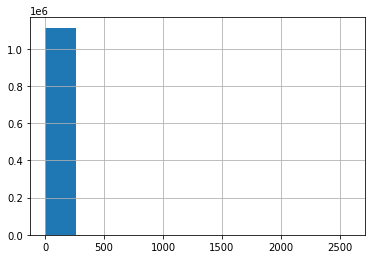

In [92]:
# Просмотр распределения
data_enriched['vote'].hist(bins=10)
outlier_detect(data_enriched, data_enriched['vote'])

Lower Range:
0.0
Upper Range:
0.0
Lower Outliers:
0
Upper Outliers:
155453


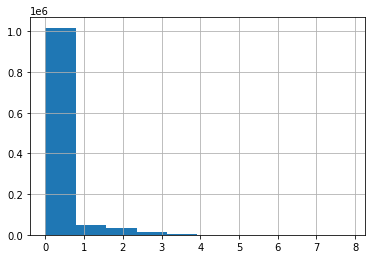

In [93]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['vote']).hist(bins=10)
outlier_detect(data_enriched, np.log(data_enriched['vote']))

Сильно предвзятое распределение. Около 15% выбросов. Взятие логарифма не влияет на распределение. Признак - кандидат на удаление.

## 5.3 В целом

<AxesSubplot:>

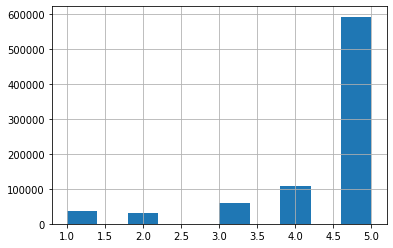

In [94]:
# Просмотр распределения
data_enriched['overall'].hist()

## 5.4 BSR (Рейтинг бестселлеров)

Lower Range:
-184202.5
Upper Range:
334689.5
Lower Outliers:
0
Upper Outliers:
71138


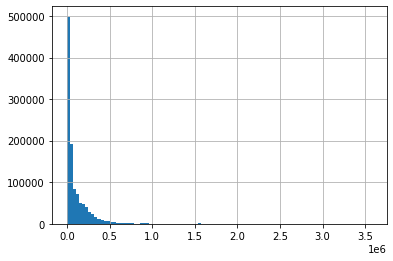

In [95]:
# Просмотр распределения
data_enriched['rank'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['rank'])

Lower Range:
5.344350910244957
Upper Range:
15.753625326624205
Lower Outliers:
30638
Upper Outliers:
0


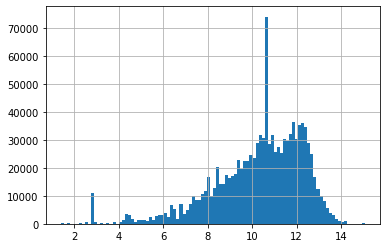

In [96]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['rank']).hist(bins=100)
outlier_detect(data_enriched, np.log(data_enriched['rank']))

## 5.5 Основная категория

In [97]:
# Просмотр данных
data_enriched['main_cat'].value_counts()

Grocery                     1055177
Health & Personal Care        42908
Amazon Home                    9324
All Beauty                     1962
Sports & Outdoors              1489
no_category_provided           1289
Industrial & Scientific        1225
Office Products                 843
Toys & Games                    402
Pet Supplies                    169
Tools & Home Improvement         74
Arts, Crafts & Sewing            25
Musical Instruments               8
Software                          5
Name: main_cat, dtype: int64

## 5.6 Цена

Lower Range:
2.7400000000000038
Upper Range:
32.739999999999995
Lower Outliers:
1055
Upper Outliers:
113561


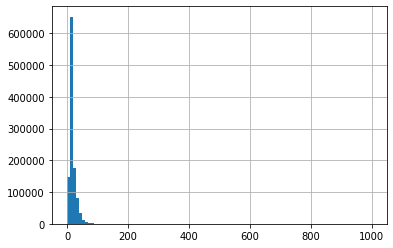

In [98]:
# Просмотр распределения
data_enriched['price'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['price'])

Lower Range:
1.9944754057118461
Upper Range:
3.7114550936199624
Lower Outliers:
66012
Upper Outliers:
53776


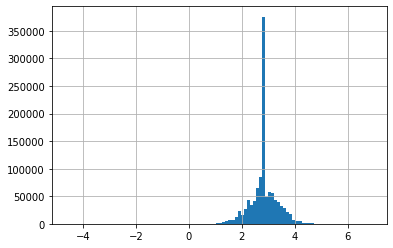

In [99]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['price']).hist(bins=100)
outlier_detect(data_enriched, np.log(data_enriched['price']))

## 5.7 Фотографии (от пользователя или поставщика)

In [100]:
# Просмотр данных пользователя
data_enriched['user_photo'].value_counts()

0    1105506
1       9394
Name: user_photo, dtype: int64

In [101]:
# Просмотр данных поставщика
data_enriched['vendor_photo'].value_counts()

1    994567
0    120333
Name: vendor_photo, dtype: int64

## 5.8 Отзывы пользователей

Lower Range:
-9.0
Upper Range:
31.0
Lower Outliers:
0
Upper Outliers:
115377


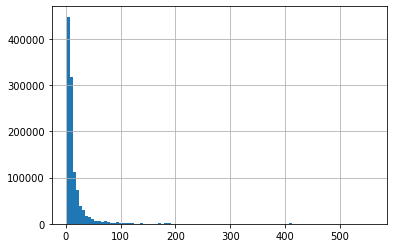

In [102]:
# Просмотр распределения
data_enriched['reviews_by_user'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['reviews_by_user'])

Lower Range:
0.3205155897104657
Upper Range:
4.24383260175737
Lower Outliers:
0
Upper Outliers:
35435


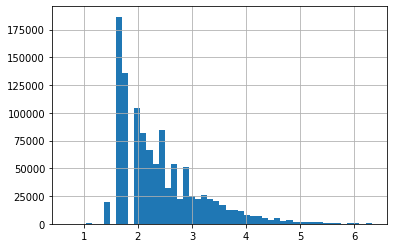

In [103]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['reviews_by_user']).hist(bins=50)
outlier_detect(data_enriched, np.log(data_enriched['reviews_by_user']))

## 5.9 Отзывы о товаре

Lower Range:
-297.0
Upper Range:
551.0
Lower Outliers:
0
Upper Outliers:
140630


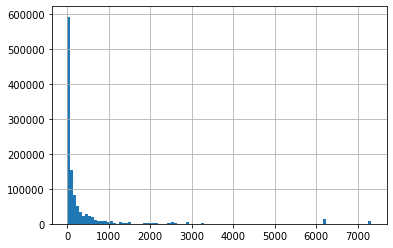

In [104]:
# Просмотр распределения
data_enriched['reviews_of_item'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['reviews_of_item'])

Lower Range:
-0.5652515860399929
Upper Range:
9.060812477329115
Lower Outliers:
0
Upper Outliers:
0


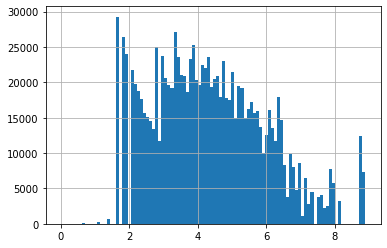

In [105]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['reviews_of_item']).hist(bins=100)
outlier_detect(data_enriched, np.log(data_enriched['reviews_of_item']))

## 5.10 Соотношение проверенных покупок

Lower Range:
0.6556473412192115
Upper Range:
1.1357719006119846
Lower Outliers:
74883
Upper Outliers:
0


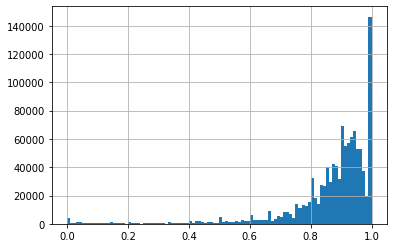

In [106]:
# Просмотр распределения
data_enriched['verified_purchases_ratio'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['verified_purchases_ratio'])

Lower Range:
-0.03212605876802288
Upper Range:
1.3541860320705976
Lower Outliers:
0
Upper Outliers:
0


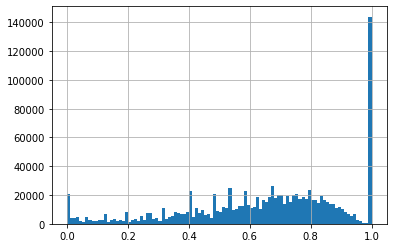

In [107]:
# Просмотр распределения после преобразования
(data_enriched['verified_purchases_ratio']**4).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['verified_purchases_ratio']**4))

## 5.11 Количество хороших/плохих отзывов

In [108]:
# Просмотр данных
data_enriched['good_review'].value_counts()

1    645087
0    469813
Name: good_review, dtype: int64

In [109]:
# Просмотр данных
data_enriched['good_summary'].value_counts()

0    756533
1    358367
Name: good_summary, dtype: int64

In [110]:
# Просмотр данных
data_enriched['bad_review'].value_counts()

0    1047517
1      67383
Name: bad_review, dtype: int64

In [111]:
# Просмотр данных
data_enriched['bad_summary'].value_counts()

0    1099723
1      15177
Name: bad_summary, dtype: int64

## 5.12 Хорошие отзывы за товар

Lower Range:
-171.0
Upper Range:
317.0
Lower Outliers:
0
Upper Outliers:
138329


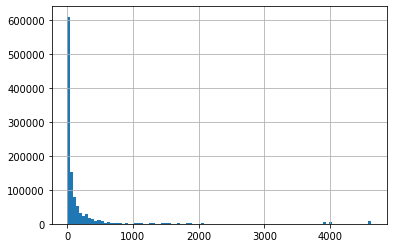

In [112]:
# Просмотр распределения
data_enriched['item_good_reviews'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['item_good_reviews'])

Lower Range:
0.7572766673462652
Upper Range:
2.156775831721066
Lower Outliers:
944
Upper Outliers:
19732


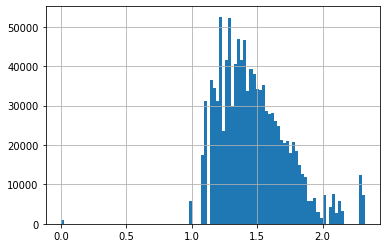

In [113]:
# Просмотр распределения после преобразования
(data_enriched['item_good_reviews']**0.1).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['item_good_reviews']**0.1))

## 5.13 Плохие отзывы за товар

Lower Range:
-15.5
Upper Range:
28.5
Lower Outliers:
0
Upper Outliers:
150332


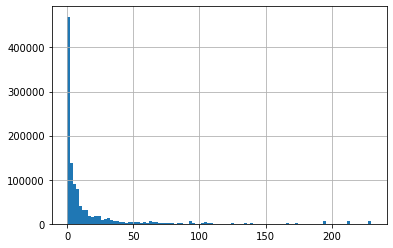

In [114]:
# Просмотр распределения
data_enriched['item_bad_reviews'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['item_bad_reviews'])

Lower Range:
-0.6611538490167066
Upper Range:
3.768589748361178
Lower Outliers:
0
Upper Outliers:
53171


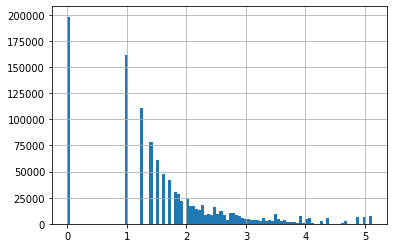

In [115]:
# Просмотр распределения после преобразования
(data_enriched['item_bad_reviews']**0.3).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['item_bad_reviews']**0.3))

## 5.14 Хорошие отзывы на бренд

Lower Range:
-2170.5
Upper Range:
3953.5
Lower Outliers:
0
Upper Outliers:
113336


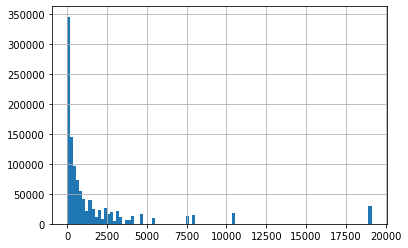

In [116]:
# Просмотр распределения
data_enriched['brand_good_reviews'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_good_reviews'])

Lower Range:
0.9069524775064287
Upper Range:
2.8136084787997593
Lower Outliers:
179
Upper Outliers:
0


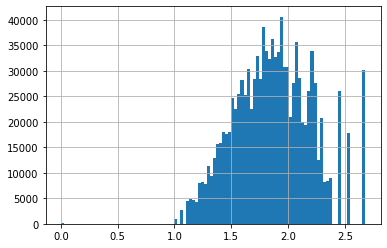

In [117]:
# Просмотр распределения после преобразования
(data_enriched['brand_good_reviews']**0.1).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['brand_good_reviews']**0.1))

## 5.15 Плохие отзывы на бренд

Lower Range:
-228.5
Upper Range:
415.5
Lower Outliers:
0
Upper Outliers:
82277


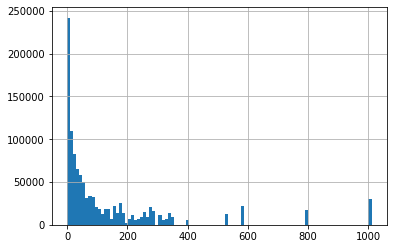

In [118]:
# Просмотр распределения
data_enriched['brand_bad_reviews'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_bad_reviews'])

Lower Range:
-1.6544517440281044
Upper Range:
8.513829825171053
Lower Outliers:
0
Upper Outliers:
0


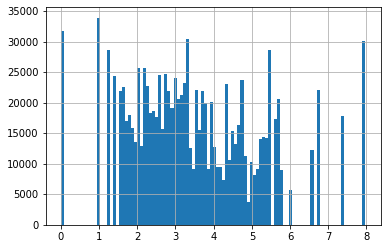

In [119]:
# Просмотр распределения после преобразования
(data_enriched['brand_bad_reviews']**0.3).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['brand_bad_reviews']**0.3))

## 5.16 Среднее значение в целом по бренду

Lower Range:
3.938233493213593
Upper Range:
4.98099295846515
Lower Outliers:
42008
Upper Outliers:
5365


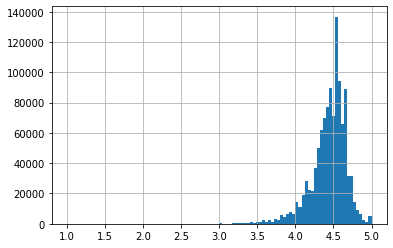

In [120]:
# Просмотр распределения
data_enriched['brand_mean_overall'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_mean_overall'])

Lower Range:
6879.09014001274
Upper Range:
64544.76303394739
Lower Outliers:
7770
Upper Outliers:
9991


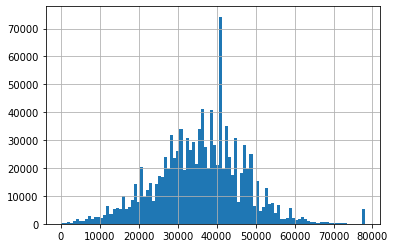

In [121]:
# Просмотр распределения после преобразования
(data_enriched['brand_mean_overall']**7).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['brand_mean_overall']**7))

## 5.17 Медиана в целом по бренду

Lower Range:
5.0
Upper Range:
5.0
Lower Outliers:
35304
Upper Outliers:
0


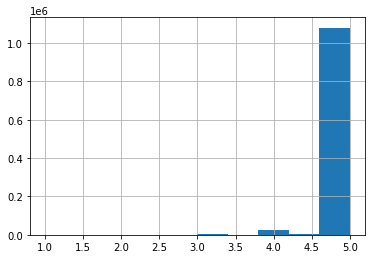

In [122]:
# Просмотр распределения
data_enriched['brand_median_overall'].hist(bins=10)
outlier_detect(data_enriched, data_enriched['brand_median_overall'])

Lower Range:
1.174618943088019
Upper Range:
1.174618943088019
Lower Outliers:
35304
Upper Outliers:
0


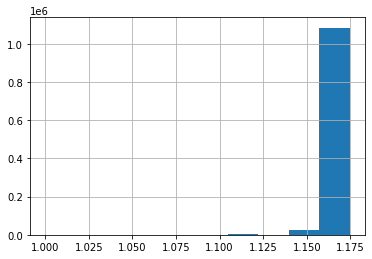

In [123]:
# Просмотр распределения после преобразования
(data_enriched['brand_median_overall']**0.1).hist(bins=10)
outlier_detect(data_enriched, (data_enriched['brand_median_overall']**0.1))

## 5.18 Соотношение проверенных покупок на бренд

Lower Range:
0.6831831831831833
Upper Range:
1.0835835835835836
Lower Outliers:
52042
Upper Outliers:
0


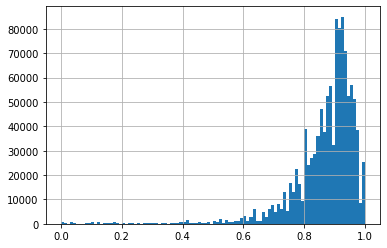

In [124]:
# Просмотр распределения
data_enriched['brand_verified_ratio'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_verified_ratio'])

Lower Range:
-0.058244282855062945
Upper Range:
1.1687473301356677
Lower Outliers:
0
Upper Outliers:
0


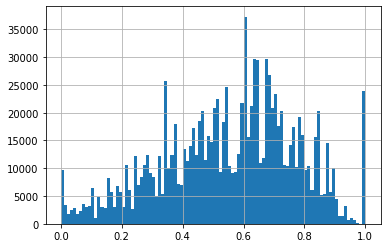

In [125]:
# Просмотр распределения после преобразования
(data_enriched['brand_verified_ratio']**5).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['brand_verified_ratio']**5))

## 5.19 Товаров на бренд

Lower Range:
-3688.0
Upper Range:
6728.0
Lower Outliers:
0
Upper Outliers:
120897


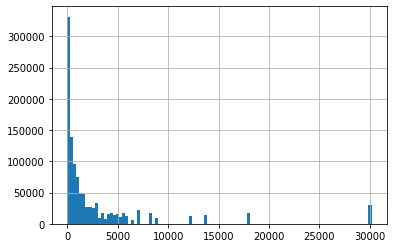

In [126]:
# Просмотр распределения
data_enriched['items_per_brand'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['items_per_brand'])

Lower Range:
0.9633028085504791
Upper Range:
2.963424028204431
Lower Outliers:
0
Upper Outliers:
0


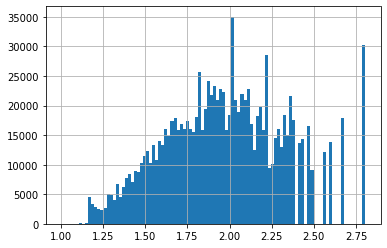

In [127]:
# Просмотр распределения после преобразования
(data_enriched['items_per_brand']**0.1).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['items_per_brand']**0.1))

## 5.20 Не купить\Посмотреть

In [128]:
# Просмотр данных
data_enriched['no_also_buy'].value_counts()

0    954886
1    160014
Name: no_also_buy, dtype: int64

In [129]:
# Просмотр данных
data_enriched['no_also_view'].value_counts()

0    602016
1    512884
Name: no_also_view, dtype: int64

## 5.21 Количество предметов "Также Купить"

Lower Range:
-80.5
Upper Range:
195.5
Lower Outliers:
0
Upper Outliers:
0


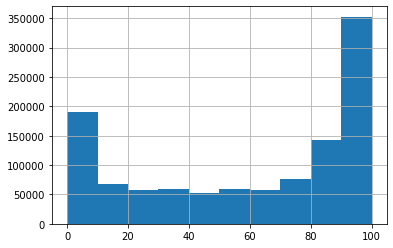

In [130]:
# Просмотр распределения
data_enriched['also_buy_number'].hist(bins=10)
outlier_detect(data_enriched, data_enriched['also_buy_number'])

## 5.22 Количество предметов "Также Посмотреть"

Lower Range:
-73.5
Upper Range:
122.5
Lower Outliers:
0
Upper Outliers:
0


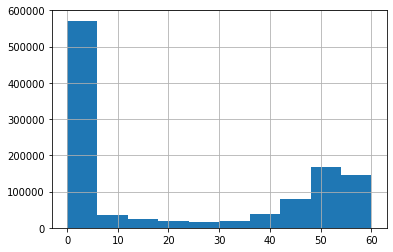

In [131]:
# Просмотр распределения
data_enriched['also_view_number'].hist(bins=10)
outlier_detect(data_enriched, data_enriched['also_view_number'])

## 5.23 Наличие ценового диапазона

In [132]:
# Просмотр данных
data_enriched['price_range'].value_counts()

0    1109603
1       5297
Name: price_range, dtype: int64

## 5.24 Средняя цена за категорию

In [133]:
# Просмотр данных
data_enriched['category_mean_price'].value_counts()

19.732939    1055177
18.224714      42908
14.729909       9324
13.240275       1962
13.350651       1489
15.648588       1289
26.988106       1225
18.172278        843
10.667015        402
26.374083        169
31.738514         74
14.450000         25
27.500000          8
30.300000          5
Name: category_mean_price, dtype: int64

## 5.25 Медианная цена за категорию

In [134]:
# Просмотр данных
data_enriched['category_median_price'].value_counts()

16.99    1055177
15.53      42908
14.17       9324
12.63       1962
9.12        1489
13.95       1289
20.99       1225
16.97        843
9.17         402
36.68        169
34.99         74
9.95          25
27.50          8
30.30          5
Name: category_median_price, dtype: int64

## 5.26 Средняя цена за бренд

Lower Range:
5.937917166867059
Upper Range:
31.2819027611039
Lower Outliers:
4370
Upper Outliers:
72080


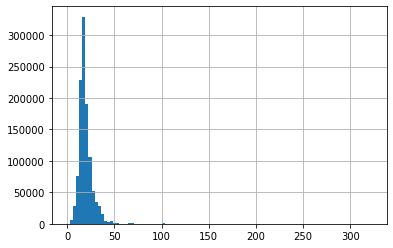

In [135]:
# Просмотр распределения
data_enriched['brand_mean_price'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_mean_price'])

Lower Range:
2.2213692862757077
Upper Range:
3.5966121385787004
Lower Outliers:
26284
Upper Outliers:
25975


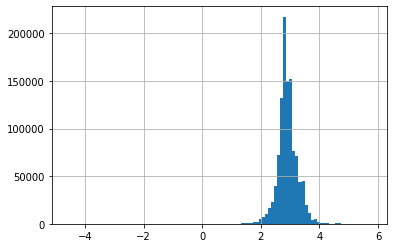

In [136]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['brand_mean_price']).hist(bins=100)
outlier_detect(data_enriched, np.log(data_enriched['brand_mean_price']))

## 5.27 Медианная цена за бренд

Lower Range:
10.490000000000002
Upper Range:
22.489999999999995
Lower Outliers:
91255
Upper Outliers:
175047


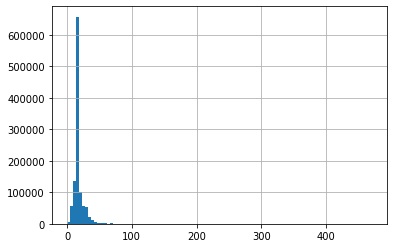

In [137]:
# Просмотр распределения
data_enriched['brand_median_price'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['brand_median_price'])

Lower Range:
2.433734208342603
Upper Range:
3.1634651517343446
Lower Outliers:
118657
Upper Outliers:
159265


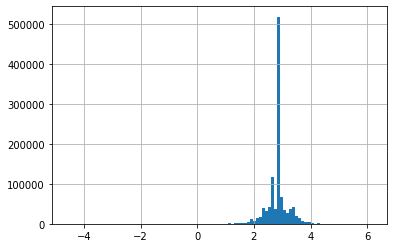

In [138]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['brand_median_price']).hist(bins=100)
outlier_detect(data_enriched, np.log(data_enriched['brand_median_price']))

## 5.28 Среднее значение в целом по товару

Lower Range:
3.683016686657463
Upper Range:
5.274744268676308
Lower Outliers:
46568
Upper Outliers:
0


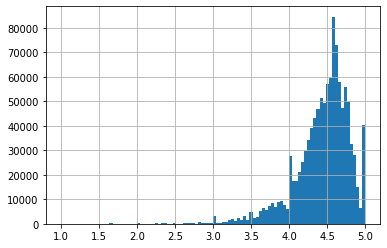

In [139]:
# Просмотр распределения
data_enriched['item_mean_overall'].hist(bins=100)
outlier_detect(data_enriched, data_enriched['item_mean_overall'])

Lower Range:
-351.2670192937594
Upper Range:
16975.458468075372
Lower Outliers:
0
Upper Outliers:
0


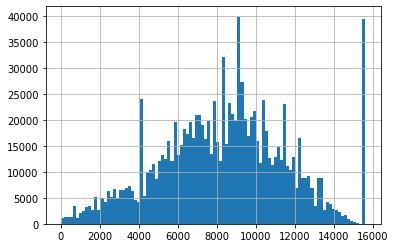

In [140]:
# Просмотр распределения после преобразования
(data_enriched['item_mean_overall']**6).hist(bins=100)
outlier_detect(data_enriched, (data_enriched['item_mean_overall']**6))

## 5.29 Медиана в целом по товару

Lower Range:
5.0
Upper Range:
5.0
Lower Outliers:
106856
Upper Outliers:
0


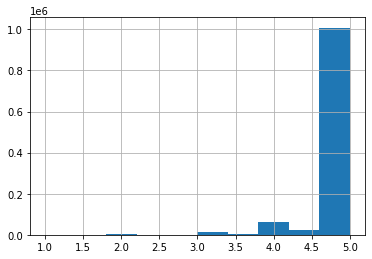

In [141]:
# Просмотр распределения
data_enriched['item_median_overall'].hist(bins=10)
outlier_detect(data_enriched, data_enriched['item_median_overall'])

Lower Range:
1.6094379124341003
Upper Range:
1.6094379124341003
Lower Outliers:
106856
Upper Outliers:
0


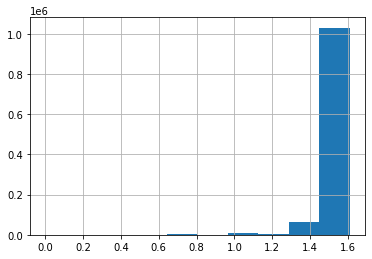

In [142]:
# Просмотр распределения после логорифмирования
np.log(data_enriched['item_median_overall']).hist(bins=10)
outlier_detect(data_enriched, np.log(data_enriched['item_median_overall']))

## 5.30 Массовые операции с признаками

In [143]:
# Переобразования признаков
data_enriched['rank'] = np.log(data_enriched['rank'])
data_enriched['price'] = np.log(data_enriched['price'])
data_enriched['reviews_by_user'] = np.log(data_enriched['reviews_by_user'])
data_enriched['reviews_of_item'] = np.log(data_enriched['reviews_of_item'])
data_enriched['verified_purchases_ratio'] = data_enriched['verified_purchases_ratio']**4
data_enriched['item_good_reviews'] = data_enriched['item_good_reviews']**0.1
data_enriched['item_bad_reviews'] = data_enriched['item_bad_reviews']**0.3
data_enriched['brand_good_reviews'] = data_enriched['brand_good_reviews']**0.1
data_enriched['brand_bad_reviews'] = data_enriched['brand_bad_reviews']**0.3
data_enriched['brand_mean_overall'] = data_enriched['brand_mean_overall']**7
data_enriched['brand_verified_ratio'] = data_enriched['brand_verified_ratio']**5
data_enriched['items_per_brand'] = data_enriched['items_per_brand']**0.1
data_enriched['brand_mean_price'] = np.log(data_enriched['brand_mean_price'])
data_enriched['item_mean_overall'] = data_enriched['item_mean_overall']**6

In [144]:
# Удаление ненужных признаков
data_enriched = data_enriched.drop(['vote', 
                                    'brand_median_overall', 
                                    'brand_median_price'], axis=1)

# 6. Важность функции

<AxesSubplot:>

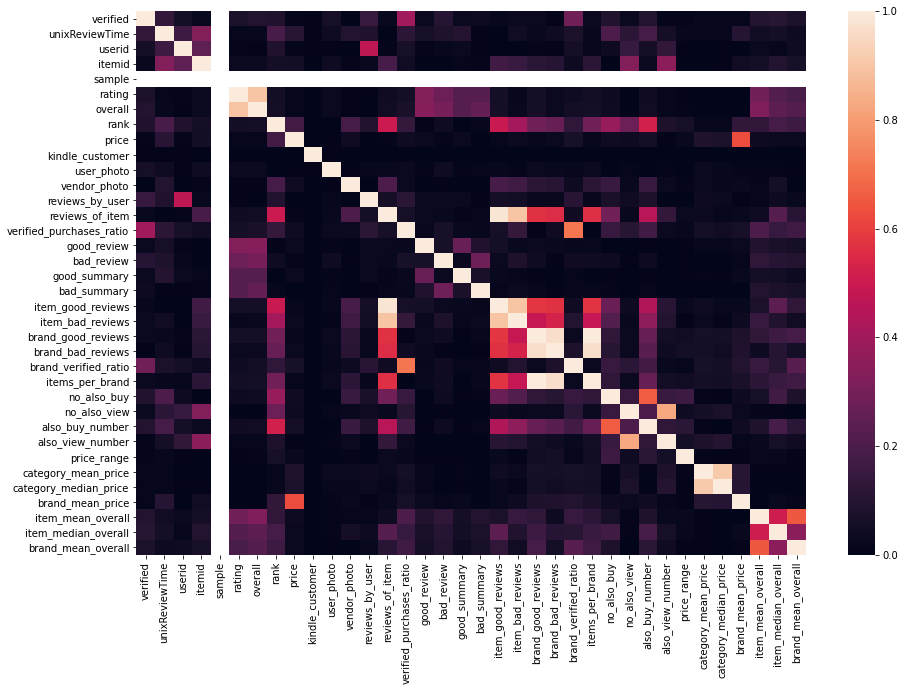

In [145]:
# Расчёт и вывод корреляционной матрицы
data_no_test = data_enriched[data_enriched['sample']==1]
plt.subplots(figsize=(15,10))
sns.heatmap(data_no_test.corr().abs(), vmin=0, vmax=1)

In [146]:
# Просмотр данных корреляционной матрицы
data_no_test.corr().abs().sort_values(by='rank', ascending=False)['rank']

rank                        1.000000
also_buy_number             0.519782
reviews_of_item             0.497975
item_good_reviews           0.493752
item_bad_reviews            0.407058
no_also_buy                 0.378706
brand_good_reviews          0.288606
items_per_brand             0.286188
no_also_view                0.273482
brand_bad_reviews           0.261738
unixReviewTime              0.189978
vendor_photo                0.183018
item_median_overall         0.179871
price                       0.176226
brand_mean_overall          0.158120
verified_purchases_ratio    0.138717
brand_mean_price            0.131638
item_mean_overall           0.126008
brand_verified_ratio        0.121119
reviews_by_user             0.088554
userid                      0.082878
verified                    0.082551
also_view_number            0.077834
price_range                 0.060607
overall                     0.057513
itemid                      0.055125
rating                      0.050460
b

In [147]:
# Просмотр данных корреляционной матрицы
data_no_test.corr().abs().sort_values(by='reviews_of_item', ascending=False)['reviews_of_item']

reviews_of_item             1.000000
item_good_reviews           0.984351
item_bad_reviews            0.895192
brand_good_reviews          0.569271
items_per_brand             0.564945
brand_bad_reviews           0.554863
rank                        0.497975
also_buy_number             0.455960
no_also_buy                 0.288793
item_median_overall         0.225800
vendor_photo                0.201221
itemid                      0.191164
also_view_number            0.132999
brand_mean_overall          0.105548
verified_purchases_ratio    0.060598
reviews_by_user             0.055628
overall                     0.045426
rating                      0.042469
brand_verified_ratio        0.040087
item_mean_overall           0.038695
category_mean_price         0.030097
price_range                 0.027447
good_review                 0.027083
bad_review                  0.021430
brand_mean_price            0.020888
no_also_view                0.020368
user_photo                  0.019732
v

Признаки, которые сильно коррелируют с большим количеством признаков: 
- rank,
- reviews_of_item,
- item_good_reviews,
- item_bad_reviews,
- brand_good_reviews,
- brand_bad_reviews,
- items_per_brand,
- also_buy_number.

In [148]:
# Удаляение из данных коррелирующих признаков
data_enriched = data_enriched.drop([
    'rank', 
    'reviews_of_item',
    'item_bad_reviews',  
    'brand_bad_reviews',
    'overall',
    'category',
    'brand',
    'also_view',
    'also_buy'
], axis=1)

In [149]:
# Просмотр данных корреляционной матрицы
data_no_test.corr().abs().sort_values(by='rating', ascending=False)['rating']

rating                      1.000000
overall                     0.897332
good_review                 0.329562
item_mean_overall           0.291755
bad_review                  0.273653
bad_summary                 0.226322
good_summary                0.223883
item_median_overall         0.216189
brand_mean_overall          0.194837
verified                    0.072100
verified_purchases_ratio    0.054207
brand_good_reviews          0.052693
item_good_reviews           0.052117
rank                        0.050460
items_per_brand             0.049509
reviews_of_item             0.042469
also_buy_number             0.041100
brand_verified_ratio        0.037967
no_also_buy                 0.032343
itemid                      0.025569
brand_bad_reviews           0.024085
user_photo                  0.023878
item_bad_reviews            0.018479
also_view_number            0.013282
price                       0.012854
unixReviewTime              0.012853
userid                      0.009931
p

In [150]:
# Просмотр данных
pd.set_option('display.max_columns', None)
data_enriched.info()
data_enriched.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 32 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   verified                  1114900 non-null  int64  
 1   unixReviewTime            1114900 non-null  int64  
 2   userid                    1114900 non-null  int64  
 3   itemid                    1114900 non-null  int64  
 4   sample                    1114900 non-null  int64  
 5   rating                    1114900 non-null  float64
 6   main_cat                  1114900 non-null  object 
 7   price                     1114900 non-null  float64
 8   kindle_customer           1114900 non-null  int64  
 9   user_photo                1114900 non-null  int64  
 10  vendor_photo              1114900 non-null  int64  
 11  reviews_by_user           1114900 non-null  float64
 12  verified_purchases_ratio  1114900 non-null  float64
 13  good_review               1

,verified,unixReviewTime,userid,itemid,sample,rating,main_cat,price,kindle_customer,user_photo,vendor_photo,reviews_by_user,verified_purchases_ratio,good_review,bad_review,good_summary,bad_summary,item_good_reviews,brand_good_reviews,brand_verified_ratio,items_per_brand,no_also_buy,no_also_view,also_buy_number,also_view_number,price_range,category_mean_price,category_median_price,brand_mean_price,item_mean_overall,item_median_overall,brand_mean_overall
0,1,1475280000,68877,7506,0,-1.0,Grocery,3.664843,0,0,1,1.791759,0.758835,0,0,0,0,1.258925,1.282089,0.79247,1.362204,0,1,75.0,0.0,0,19.732939,16.99,3.423878,13841.287201,5.0,64657.84227
1,1,1453248000,58293,7506,0,-1.0,Grocery,3.664843,0,0,1,1.791759,0.758835,0,0,0,0,1.258925,1.282089,0.79247,1.362204,0,1,75.0,0.0,0,19.732939,16.99,3.423878,13841.287201,5.0,64657.84227
2,1,1486252800,36496,7506,0,-1.0,Grocery,3.664843,0,0,1,2.639057,0.758835,0,0,0,0,1.258925,1.282089,0.79247,1.362204,0,1,75.0,0.0,0,19.732939,16.99,3.423878,13841.287201,5.0,64657.84227
3,1,1361664000,95606,7506,0,-1.0,Grocery,3.664843,0,0,1,2.302585,0.758835,0,0,0,0,1.258925,1.282089,0.79247,1.362204,0,1,75.0,0.0,0,19.732939,16.99,3.423878,13841.287201,5.0,64657.84227
4,1,1433980800,15601,7506,0,-1.0,Grocery,3.664843,1,0,1,2.564949,0.758835,0,0,0,0,1.258925,1.282089,0.79247,1.362204,0,1,75.0,0.0,0,19.732939,16.99,3.423878,13841.287201,5.0,64657.84227


In [151]:
# Группировка имен столбцов по типу данных.
cat_cols = ['category_median_price', 
            'item_median_overall']

bin_cols = ['verified', 
            'kindle_customer', 
            'user_photo', 
            'vendor_photo', 
            'good_review', 
            'bad_review', 
            'good_summary', 
            'bad_summary', 
            'no_also_buy', 
            'no_also_view', 
            'price_range']

num_cols = ['unixReviewTime',
            'price',
            'reviews_by_user',
            'verified_purchases_ratio',
            'brand_verified_ratio', 
            'also_view_number', 
            'category_mean_price', 
            'brand_mean_price', 
            'item_mean_overall', 
            'brand_mean_overall', 
            'item_good_reviews',
            'brand_good_reviews', 
            'items_per_brand', 
            'also_buy_number']

<AxesSubplot:>

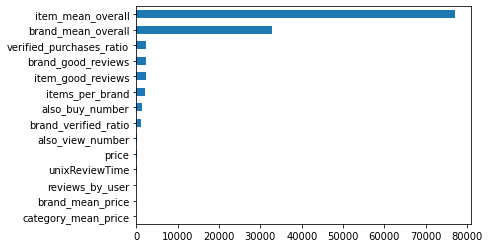

In [152]:
# Проверка важности функций
imp_num = Series(f_classif(data_no_test[num_cols], 
                           data_no_test['rating'])[0], index = num_cols)

imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

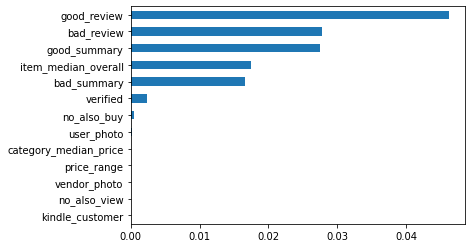

In [153]:
# Проверка важности функций.
imp_cat = Series(mutual_info_classif(data_no_test[bin_cols + cat_cols], 
                                     data_no_test['rating'], 
                                     discrete_features =True), index = bin_cols + cat_cols)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# 7. Подготовка к машинному обучению

In [154]:
# One-hot encoding.
data_enriched = pd.get_dummies(data_enriched, columns=['main_cat'], dummy_na=True)

In [155]:
# Нормализация данных (кроме целевой переменной и идентификаторов)
data_no_rating = data_enriched[
    data_enriched.columns.difference([
        'rating', 
        'userid', 
        'itemid'])]

data_no_rating[data_no_rating.columns] = pd.DataFrame(
    scaler.fit_transform(data_no_rating[data_no_rating.columns]))

data_no_rating['rating'] = data_enriched['rating']
data_no_rating['userid'] = data_enriched['userid']
data_no_rating['itemid'] = data_enriched['itemid']

data_enriched = data_no_rating

In [156]:
# Просмотр данных
data_enriched.info()
data_enriched.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114900 entries, 0 to 1114899
Data columns (total 46 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   also_buy_number                    1114900 non-null  float64
 1   also_view_number                   1114900 non-null  float64
 2   bad_review                         1114900 non-null  float64
 3   bad_summary                        1114900 non-null  float64
 4   brand_good_reviews                 1114900 non-null  float64
 5   brand_mean_overall                 1114900 non-null  float64
 6   brand_mean_price                   1114900 non-null  float64
 7   brand_verified_ratio               1114900 non-null  float64
 8   category_mean_price                1114900 non-null  float64
 9   category_median_price              1114900 non-null  float64
 10  good_review                        1114900 non-null  float64
 11  good_summary            

,also_buy_number,also_view_number,bad_review,bad_summary,brand_good_reviews,brand_mean_overall,brand_mean_price,brand_verified_ratio,category_mean_price,category_median_price,good_review,good_summary,item_good_reviews,item_mean_overall,item_median_overall,items_per_brand,kindle_customer,main_cat_All Beauty,main_cat_Amazon Home,"main_cat_Arts, Crafts & Sewing",main_cat_Grocery,main_cat_Health & Personal Care,main_cat_Industrial & Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Tools & Home Improvement,main_cat_Toys & Games,main_cat_nan,main_cat_no_category_provided,no_also_buy,no_also_view,price,price_range,reviews_by_user,sample,unixReviewTime,user_photo,vendor_photo,verified,verified_purchases_ratio,rating,userid,itemid
0,0.75,0.0,0.0,0.0,0.478391,0.827618,0.773419,0.79247,0.430246,0.285559,0.0,0.0,0.541317,0.885835,1.0,0.200658,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.718387,0.0,0.195093,0.0,0.889710,0.0,1.0,1.0,0.758835,-1.0,68877,7506
1,0.75,0.0,0.0,0.0,0.478391,0.827618,0.773419,0.79247,0.430246,0.285559,0.0,0.0,0.541317,0.885835,1.0,0.200658,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.718387,0.0,0.195093,0.0,0.851237,0.0,1.0,1.0,0.758835,-1.0,58293,7506
2,0.75,0.0,0.0,0.0,0.478391,0.827618,0.773419,0.79247,0.430246,0.285559,0.0,0.0,0.541317,0.885835,1.0,0.200658,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.718387,0.0,0.345558,0.0,0.908871,0.0,1.0,1.0,0.758835,-1.0,36496,7506
3,0.75,0.0,0.0,0.0,0.478391,0.827618,0.773419,0.79247,0.430246,0.285559,0.0,0.0,0.541317,0.885835,1.0,0.200658,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.718387,0.0,0.285807,0.0,0.691310,0.0,1.0,1.0,0.758835,-1.0,95606,7506
4,0.75,0.0,0.0,0.0,0.478391,0.827618,0.773419,0.79247,0.430246,0.285559,0.0,0.0,0.541317,0.885835,1.0,0.200658,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.718387,0.0,0.332398,0.0,0.817592,0.0,1.0,1.0,0.758835,-1.0,15601,7506


Отбросим признаки, которые непосредственно не связаны с тестовым набором данных.

In [157]:
# Удаление признаков
data_ml = data_enriched.drop([
    'price', 
    'good_review', 
    'bad_review', 
    'good_summary', 
    'bad_summary', 
    'brand_good_reviews', 
    'brand_verified_ratio', 
    'items_per_brand', 
    'price_range', 
    'category_mean_price', 
    'category_median_price', 
    'brand_mean_price', 
    'brand_mean_overall'], axis=1)

# 7. Машинное обучение

In [158]:
train = data_ml.query('sample == 1').drop('sample', axis = 1)
test = data_ml.query('sample == 0').drop(['sample', 'rating'], axis = 1)

In [159]:
train_data, test_data = train_test_split(train,
                                         random_state = RANDOM_STATE, 
                                         shuffle = True)

ratings_coo = sparse.coo_matrix(
    (train_data['rating'].astype(int), (train_data['userid'], train_data['itemid']))
)

model = LightFM(learning_rate = LEARNING_RATE, 
                loss = LOSS_FUNCTION,
                no_components = NUM_COMPONENTS,
                random_state = RANDOM_STATE,
                learning_schedule = LEARNING_SCHEDULE)

model = model.fit(ratings_coo, 
                  epochs = NUM_EPOCHS, 
                  num_threads = NUM_THREADS)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

sklearn.metrics.roc_auc_score(test_data.rating, preds)

0.7259581544465675

In [160]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

submission['rating'] = normalized_preds

submission.to_csv('submission_log.csv', index=False)

In [161]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

submission['rating'] = normalized_preds

submission.to_csv('submission_log.csv', index=False)

# 8. Резюме и выводы

Стоит признать, что код требует значительных улучшений, так как при создании функций были допущены логические ошибки. В тестовом наборе данных отсутствует ряд переменных, поэтому мы не можем использовать связанные переменные для обучения модели. Нам также необходимо оптимизировать гиперпараметры, создать пользовательский интерфейс с помощью сервиса Streamlight и загрузить прототип в Heroku.